<a href="https://colab.research.google.com/github/PrageshShrestha/Newari2English/blob/main/Newari2English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence , pad_packed_sequence
import os
import math
from transformers import BertModel, AutoModel, BertTokenizer, AutoTokenizer
from google.colab import drive
from datasets import load_dataset


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
config = {
    "embedding_dims":768,
    "vocab_size":30522,
    "nep_vocab_size":50000,
    "hidden_size":1024,
    "epoches":10,
    "dropout":0.3,
    "batch_size":15,
    "max_seq_length":50,
    "num_layers":5,
    "num_heads":2,
    "device":device,
}

In [4]:

# Load dataset
ds = load_dataset("Unspoiled-Egg/indigenous-eng-translation")

# Load tokenizers
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # English BERT
nepali_tokenizer = AutoTokenizer.from_pretrained("Rajan/NepaliBERT")  # NepaliBERT for Newari
bert_en = BertModel.from_pretrained("bert-base-uncased")
bert_ne = AutoModel.from_pretrained("Rajan/NepaliBERT")
def get_tokens(sentence, tokenizer, return_details=False):
    tokens = tokenizer.tokenize(sentence)

    # Convert to token IDs
    token_ids = tokenizer.encode(sentence, add_special_tokens=True)  # Adds [CLS] and [SEP]

    if return_details:
        token_id_pairs = list(zip(tokens, token_ids[1:-1]))  # Exclude [CLS] and [SEP] for mapping
        return {
            "tokens": tokens,
            "token_ids": token_ids,
            "token_id_pairs": token_id_pairs,
            "decoded": tokenizer.decode(token_ids, skip_special_tokens=True)
        }
    return token_ids

# Function to get embeddings as a tensor of shape (seq_len, embedding_dim)
def get_initial_embedding(sentence, tokenizer, model):
    # Tokenize and get token IDs
    token_ids = tokenizer.encode(sentence, add_special_tokens=True)
    token_tensor = torch.tensor([token_ids])  # Shape: (1, seq_len)

    with torch.no_grad():
        embeddings = model.get_input_embeddings()(token_tensor)  # Shape: (1, seq_len, embedding_dim)

    return embeddings.squeeze(0)

# Load models
bert_en = BertModel.from_pretrained("bert-base-uncased")
bert_ne = AutoModel.from_pretrained("Rajan/NepaliBERT")

# Initialize storage
dataset_tokens = []
dataset_raw = []

# Process the first 30 entries from the dataset
for i in range(len(ds["train"])):  # Ensure not going out of range
    item = ds["train"][i]  # Get the i-th entry from the "train" dataset

    # Access the 'translation' dictionary and extract the 'new' and 'en' values
    en_new = item["translation"]


    # Now, we can access 'new' and 'en' safely
    dataset_raw.append((en_new["new"], en_new["en"]))  # Append 'new' and 'en' columns

    # Get embeddings for English and Nepali
    #bert_tokens = get_initial_embedding(en_new["en"], bert_tokenizer, bert_en)
    #nepali_tokens = get_initial_embedding(en_new["new"], nepali_tokenizer, bert_ne)
    bert_tokens = get_tokens(en_new["en"], bert_tokenizer)
    nepali_tokens = get_tokens(en_new["new"], nepali_tokenizer)

    # Get token IDs for English
    tokens_en = get_tokens(en_new["en"], bert_tokenizer, return_details=True).get("token_ids")

    dataset_tokens.append((nepali_tokens, bert_tokens, tokens_en))



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at Rajan/NepaliBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at Rajan/NepaliBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably T

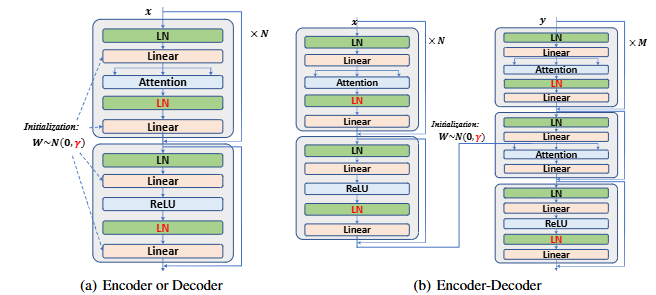

SOURCE OF DIAGRAM : extension://bfdogplmndidlpjfhoijckpakkdjkkil/pdf/viewer.html?file=https%3A%2F%2Farxiv.org%2Fpdf%2F2210.06423

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to save model
MODEL_PATH = "/content/drive/MyDrive/transformer_SAMPLE.pth"

def save_model(model, loss, model_path = MODEL_PATH):

    torch.save(model.state_dict(), model_path)  # Saves model's state_dict instead of full model
    print(f"Model saved with loss: {loss:.5f}")

def load_model( model_path=MODEL_PATH, config=None):
    model = Transformer(config)
    """
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        model.eval()
        print("Loaded existing model from Drive.")
    else:
        print("No existing model found. Training a new one.")
        model = Transformer()
    """
    return model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
class Transformer(nn.Module):
  def __init__(self,config=config):
    super().__init__()
    self.config = config
    self.embedding = nn.Embedding(num_embeddings = int(self.config["vocab_size"]+10) , embedding_dim = self.config["embedding_dims"])
    self.embedding_nep = nn.Embedding(num_embeddings = self.config["nep_vocab_size"] , embedding_dim = self.config["embedding_dims"])
    self.layer_norm = nn.RMSNorm(self.config["embedding_dims"])
    self.linear = nn.Linear(self.config["embedding_dims"] , self.config["hidden_size"])
    self.dropout = nn.Dropout(self.config["dropout"])
    self.attention = nn.MultiheadAttention(self.config["hidden_size"] , num_heads = self.config["num_heads"] , batch_first = True)
    self.layer_norm2 = nn.RMSNorm(self.config["hidden_size"])
    self.relu = F.relu
    self.attention2 = nn.MultiheadAttention(self.config["embedding_dims"] , num_heads = 2 , batch_first = True)

    self.linear2 = nn.Linear(self.config["hidden_size"] , self.config["embedding_dims"])
  def first_block_encoder(self , x):
    x = self.layer_norm(x)
    x = self.linear(x)
    x , _ = self.attention(x,x,x)
    x = self.dropout(x)
    x = self.layer_norm2(x)
    x = self.linear2(x)
    return x
  def second_block_encoder(self,x):
    x = self.layer_norm(x)
    x = self.linear(x)
    x = self.relu(x)
    x = self.layer_norm2(x)
    x =self.linear2(x)
    return x
  def second_block_decoder(self,x,encoder_output):
    x = self.layer_norm(x)
    x = self.linear(x)
    encoder_output = self.linear(encoder_output)
    #print(encoder_output.shape , x.shape)
    x , _ = self.attention(x , encoder_output , encoder_output)
    x = self.linear2(x)
    return x
  def temp_forward(self , input_encoder , input_decoder):

    #encoder input
    out_en_1 = self.first_block_encoder(input_encoder)
    out_en_1 = torch.add(out_en_1 , input_encoder)
    out_en_2 = self.second_block_encoder(out_en_1)
    out_en = torch.add(out_en_2 , out_en_1)
    #out_en = pad_packed_sequence(out_en , seq_len_encoder , batch_first = True , enforce_sorted = False)
    #decoder input turn
    out_de_1 = self.first_block_encoder(input_decoder)
    out_de_1 = torch.add(out_de_1 , input_decoder)
    #attention block / inputs mix
    #print(out_de_1.shape , out_en.shape)
    out_de_2 = self.second_block_decoder(out_de_1 , out_en)
    out_de = torch.add(out_de_2 , out_de_1)
    out_de_actual = self.second_block_encoder(out_de)
    out_de_actual = torch.add(out_de_actual , out_de)
    out_de_actual= nn.Linear(self.config["embedding_dims"] , self.config["vocab_size"])(out_de_actual)
    #original_shaped = pad_packed_sequence(out_de_actual ,seq_len_decoder, batch_first = True , enforce_sorted = False)
    #print("this is original output from model ")
    #print(original_shaped , original_shaped.shape)
    return out_de_actual

  def forward(self , input_encoder , input_decoder):
    #print(input_encoder , input_decoder)
    #print(input_encoder.shape , input_decoder.shape)
    input_encoder = self.embedding_nep(input_encoder)
    input_decoder = self.embedding(input_decoder)
    seq_len = input_decoder.size(1)
    """
    #print(input_encoder)
    seq_lengths_encoder = (input_encoder.abs().sum(dim=2) > 1e-6).sum(dim=1)
    seq_lengths_decoder = (input_decoder.abs().sum(dim=2) > 1e-6).sum(dim=1)

    print(seq_lengths_encoder , seq_lengths_decoder)
    try:
      some_type = pack_padded_sequence(input_encoder , seq_lengths_encoder , batch_first = True , enforce_sorted = False)
      input_encoder = some_type[0]
      batch_encoder = some_type[1]
      some_type2 = pack_padded_sequence(input_decoder , seq_lengths_decoder , batch_first = True , enforce_sorted = False)
      input_decoder = some_type2[0]

      print(input_encoder.shape)
    except:
      pass
    """
    key_padding_mask_encoder = (input_encoder == 0 ).any(dim=-1)
    key_padding_mask_decoder = (input_decoder == 0 ).any(dim=-1)

    input_encoder , _ = self.attention2(input_encoder,input_encoder , input_encoder , key_padding_mask = key_padding_mask_encoder)
    input_decoder , _ = self.attention2(input_decoder , input_decoder , input_decoder , key_padding_mask = key_padding_mask_decoder)

    decoder_output = []

    for i in range(1,seq_len):

      input_decoder_temp = input_decoder[:,i,:]
      input_decoder_temp = input_decoder_temp.unsqueeze(1)
      #print(input_decoder_temp.shape)

      idt = input_decoder_temp.float()
      #print(idt.shape)
      output = self.temp_forward(input_encoder , idt)
      #print(f" this is the output{output.shape}")
      decoder_output.append(output)
      #print(output)
      #print("next")
    #print(seq_len)
    decoder_outputs = sum(decoder_output)
    #print(decoder_outputs.shape)
    return decoder_outputs

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to save model
MODEL_PATH = "/content/drive/MyDrive/transformer_new.pth"

def train(dataset=dataset_tokens[:10] , config = config):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = load_model(model_path=MODEL_PATH, config=config)

    bert_en = BertModel.from_pretrained("bert-base-uncased")
    bert_ne = AutoModel.from_pretrained("Rajan/NepaliBERT")
    tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")
    tokenizer_ne = AutoTokenizer.from_pretrained("Rajan/NepaliBERT")

    optimizer = torch.optim.SGD(model.parameters(),lr = 0.02)

    criterion = nn.MSELoss()
    model = Transformer()
    batch_size = config["batch_size"]
    for epoch in range(config["epoches"]):
        #model.train()
        for i in range(0, len(dataset), batch_size):
            batch = dataset[i:i + batch_size]
            #print(i,i+batch_size)
            #print(batch[0] , batch[1] , batch[2] , sep="\n")
            newari_ids = torch.nn.utils.rnn.pad_sequence(
                [torch.tensor(item[0], dtype=torch.long) for item in batch], batch_first=True, padding_value=0)
            english_ids = torch.nn.utils.rnn.pad_sequence(
                [torch.tensor(item[1], dtype=torch.long) for item in batch], batch_first=True, padding_value=0)

            target_ids = torch.nn.utils.rnn.pad_sequence(
                [torch.tensor(item[2], dtype=torch.long) for item in batch], batch_first=True, padding_value=0)
            #print(newari_ids)
            # Forward pass through the model

            logits = model(newari_ids, english_ids)
            print("next")
            # Reshape logits and targets for CrossEntropyLoss
            #logits = logits.view(-1, config["vocab_size"])  # Flatten logits to match vocab_size
            #targets = target_ids.view(-1)  # Flatten targets for matching with logits

            # Ensure targets are within the range [0, vocab_size-1]
            #if targets.max() >= config["vocab_size"]:
                #print(f"Warning: Target value exceeds vocab_size: {targets.max()}")
            target_ids = F.one_hot(target_ids, num_classes=config["vocab_size"]).float()
            #print(logits.shape , target_ids.shape )
            loss = criterion(logits, target_ids)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} - Loss: {loss.item():.8f}")

    save_model(model, loss.item())

train()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of BertModel were not initialized from the model checkpoint at Rajan/NepaliBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


next


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10, 39, 30522])) that is different to the input size (torch.Size([10, 1, 30522])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 - Loss: 9.38314056
